In [18]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from database import SQLiteDatabase
from experiment import preliminary_setup
import query as q

In [24]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
DB_DIRECTORY = KWARGS['database_directory']
FIGURES_DIRECTORY = KWARGS['figure_directory']
DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY, 'deployment_strategy_1_0.db'))
RBC_DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY, 'rbc_reference_1.db'))
RBC_REFERENCE_COST_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'rbc_reference_1_cost_summary.csv'))
RBC_REFERENCE_LOAD_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'rbc_reference_1_load_summary.csv'))
ACTIONS = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'deployment_strategy_1_0_actions.csv'))
RBC_ACTIONS = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'rbc_reference_1_0_actions.csv'))
cost_labels = {
    'electricity_consumption': r'$D$', 
    'price': r'$C$', 
    'carbon_emission': r'$G$',
    'zero_net_energy': r'$Z$',
    'daily_peak': r'$P$',
    'ramping': r'$R$',
    'load_factor': r'$1 - L$',
}

#   Cumulative Building Reward

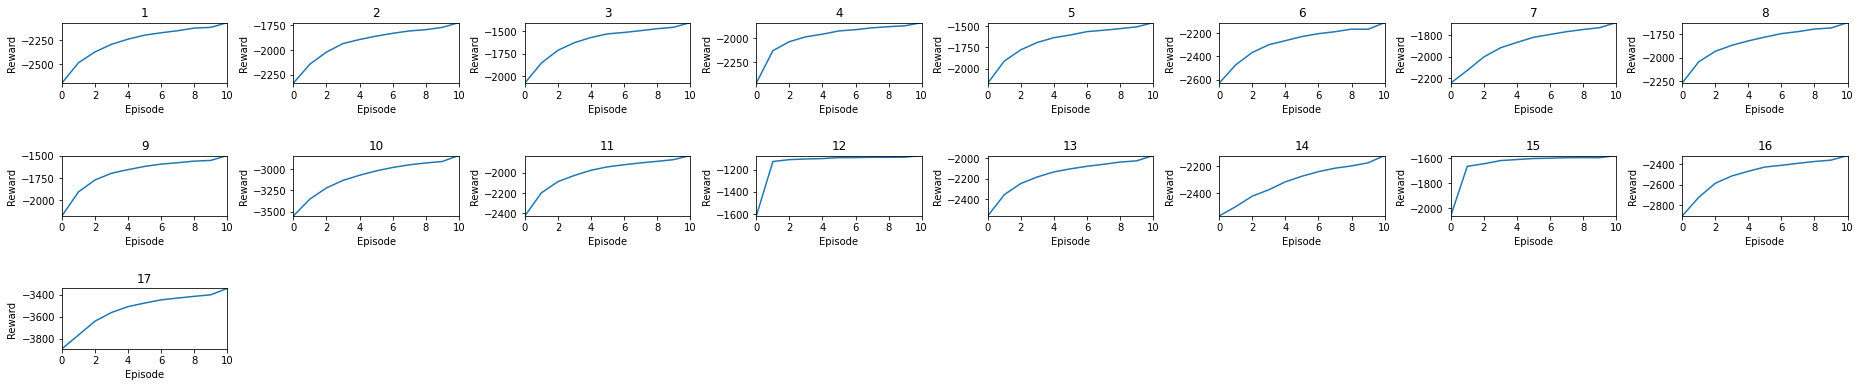

In [3]:
reward_data = DATABASE.query_table(q.get_cummulative_reward())
column_count_limit = 8
building_count = len(reward_data['building_id'].unique())
row_count = math.ceil(building_count/column_count_limit)
column_count = min(building_count, column_count_limit)
fig, _ = plt.subplots(row_count, column_count, figsize=(4*column_count, 2*row_count), gridspec_kw={'wspace':0.4, 'hspace':1.2})

for ax in fig.axes[building_count:]:
    ax.set_visible(False)

for i, (ax, (b, b_data)) in enumerate(zip(fig.axes, reward_data.groupby('building_id'))):
    x, y = b_data['episode'], b_data['value']
    ax.plot(x, y, label=b)

    ax.set_title(b)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')

plt.show()

# Building-Level Scores

In [4]:
building_cost_data = DATABASE.query_table(q.get_building_cost_summary())

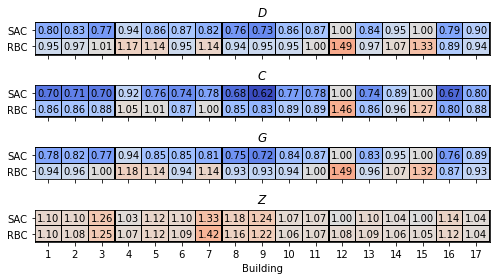

In [31]:
costs = ['electricity_consumption', 'price',  'carbon_emission', 'zero_net_energy']
row_count = len(costs)
column_count = 1
cmap = 'coolwarm'
plot_data = building_cost_data[building_cost_data['episode']==building_cost_data['episode'].max()].copy()
plot_data['agent'] = 'SAC'
rbc_plot_data = RBC_REFERENCE_COST_SUMMARY.query('scope == "building"').copy()
rbc_plot_data['agent'] = 'RBC'
plot_data = pd.concat([plot_data, rbc_plot_data], ignore_index=True, sort=False)
vcenter = 1.0
vmin = plot_data['value'].min()
vmax = plot_data['value'].max()
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
fig, ax = plt.subplots(row_count, column_count, figsize=(7*column_count,1.0*row_count), sharex=True)

for i, ax in enumerate(fig.axes):
    c_data = plot_data[plot_data['cost']==costs[i]].copy()
    c_data = c_data.pivot(index='agent', columns='building_id', values='value')
    x, y, z = c_data.columns.astype(int).astype(str), c_data.index, c_data.values
    pcm = ax.pcolormesh(x, y, z, shading='nearest', cmap=cmap, norm=divnorm, edgecolors='black', linewidth=0.1)
    # _ = fig.colorbar(pcm, ax=ax, orientation='vertical', label=None, fraction=0.025, pad=0.01)
    ax.tick_params('x', which='both', rotation=0)

    if i == row_count - 1:
        ax.set_xlabel('Building')
    else:
        ax.set_xlabel(None)

    ax.set_ylabel(None)
    ax.set_title(cost_labels[costs[i]])

    for (i, j), z in np.ndenumerate(c_data):
        color = 'black'
        ax.text(j,i,f'{z:0.2f}', ha='center', va='center', color=color)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_1_0_building_cost_summary.pdf'),bbox_inches='tight',transparent=True)
plt.show()

# District-Level Scores

In [6]:
district_cost_data = DATABASE.query_table(q.get_district_cost_summary())

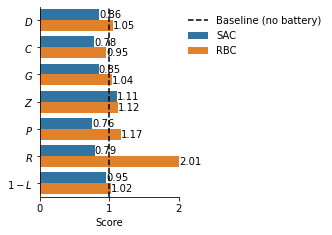

In [27]:
row_count = 1
column_count = 1
fig, ax = plt.subplots(row_count, column_count, figsize=(column_count*2.5, row_count*3.5))
plot_data = district_cost_data[district_cost_data['episode']==district_cost_data['episode'].max()].copy()
plot_data['agent'] = 'SAC'
rbc_plot_data = RBC_REFERENCE_COST_SUMMARY.query('scope == "district"').copy()
rbc_plot_data['agent'] = 'RBC'
plot_data = pd.concat([plot_data, rbc_plot_data], ignore_index=True, sort=False)
plot_data['cost_label'] = plot_data['cost'].map(lambda x: cost_labels[x])
hue_order = ['SAC', 'RBC']
sns.barplot(x='value', y='cost_label', data=plot_data, hue='agent', order=cost_labels.values(), hue_order=hue_order, ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline (no battery)')
ax.set_xlabel('Score')
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2.0, f'{p.get_width():0.2f}', ha='left', va='center')

ax.legend(
    bbox_to_anchor=(1.0,1.0),
    loc='upper left',
    framealpha=0,
    ncol=1
)

plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_1_0_district_cost_summary.pdf'),bbox_inches='tight',transparent=True)
plt.show()

# Building-Level Average Daily Profile

In [8]:
building_load_data = DATABASE.query_table(q.get_building_average_daily_profile())

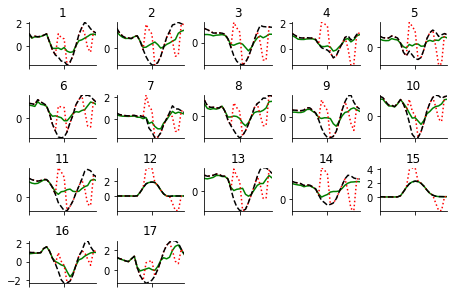

In [16]:
plot_data = building_load_data[building_load_data['episode']==building_load_data['episode'].max()].copy()
rbc_plot_data = RBC_REFERENCE_LOAD_SUMMARY[RBC_REFERENCE_LOAD_SUMMARY['scope']=='building'][[
    'building_id', 'hour', 'with_storage_value'
]].copy()
rbc_plot_data = rbc_plot_data.rename(columns={'with_storage_value': 'rbc_with_storage_value'})
plot_data = plot_data.merge(rbc_plot_data, on=['hour', 'building_id'], how='inner')
column_count_limit = 5
building_id_count = len(plot_data['building_id'].unique())
row_count, column_count = math.ceil(building_id_count/column_count_limit), min(column_count_limit, building_id_count)
fig, _ = plt.subplots(row_count, column_count, figsize=(1.5*column_count, 1.2*row_count), gridspec_kw={'wspace':0.3, 'hspace':0.7})

for ax in fig.axes[building_id_count:]:
    ax.set_visible(False)

for i, (ax, (b, b_data)) in enumerate(zip(fig.axes, plot_data.groupby(['building_id']))):
    x, y1, y2, y3 = b_data['hour'], b_data['with_storage_value'], b_data['rbc_with_storage_value'], b_data['without_storage_value']
    ax.plot(x, y1, color='green', label='SAC')
    ax.plot(x, y2, color='red', label='RBC', linestyle=':',)
    ax.plot(x, y3, color='black', linestyle='--', label='Baseline (no battery)')
    ax.set_title(b)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_tick_params(labelbottom=None)

    # if i == 0:
    #     ax.legend(
    #         bbox_to_anchor=(0.5,0),
    #         loc='upper center', 
    #         bbox_transform=fig.transFigure,
    #         framealpha=0,
    #         ncol=2
    #     )
    # else:
    #     ax.legend().set_visible(False)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    # if i%column_count == 0:
    #     ax.set_ylabel('kWh')
    # else:
    #     ax.set_ylabel(None)

fig.align_ylabels()
# plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_1_0_building_average_daily_load_profile.pdf'),bbox_inches='tight',transparent=True)
plt.show()

- Buildings 1, 2, 3, 5, 6, 8, 9, 10 ,11, 13, 14, 16 and 17 have similar shapes as they their SAC profile is the best and is different from the no control and RBC scenarios. RBC has the same general shape in these buildings as well.
- Buildings 4, 7 are similar as SAC and no control are very nearly the same. RBC shapes in these 2 buildings are the same.
- Buildings 12 and 15 are similar as SAC and no control are exactly the same.  RBC shapes in these 2 buildings are the same.

# District-Level Average Daily Profile

In [19]:
district_load_data = DATABASE.query_table(q.get_district_average_daily_profile())

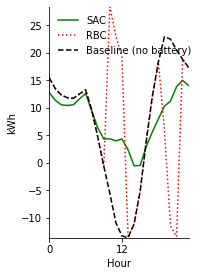

In [21]:
plot_data = district_load_data[district_load_data['episode']==district_load_data['episode'].max()].copy()
rbc_plot_data = RBC_REFERENCE_LOAD_SUMMARY[RBC_REFERENCE_LOAD_SUMMARY['scope']=='district'][[
    'hour', 'with_storage_value'
]].copy()
rbc_plot_data = rbc_plot_data.rename(columns={'with_storage_value': 'rbc_with_storage_value'})
plot_data = plot_data.merge(rbc_plot_data, on=['hour'], how='inner')
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(2.5*column_count, 4.25*row_count))

x, y1, y2, y3 = plot_data['hour'], plot_data['with_storage_value'], plot_data['rbc_with_storage_value'], plot_data['without_storage_value']
ax.plot(x, y1, color='green', label='SAC')
ax.plot(x, y2, color='red', label='RBC', linestyle=':',)
ax.plot(x, y3, color='black', linestyle='--', label='Baseline (no battery)')
ax.set_xlabel('Hour')
ax.set_ylabel('kWh')
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax.legend(
    loc='upper left', 
    framealpha=0,
    ncol=1
)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_1_0_district_average_daily_load_profile.pdf'),bbox_inches='tight',transparent=True)
plt.show()

# Profiles Snapshot for Select-Buildings

Building 2:


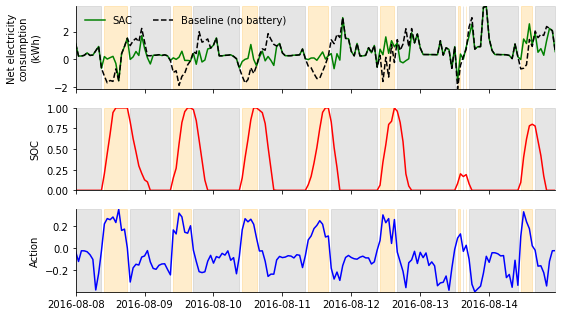

Building 4:


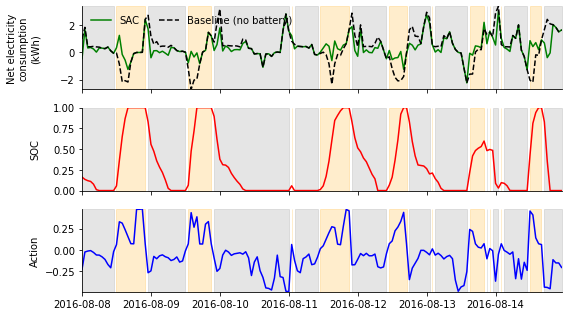

Building 7:


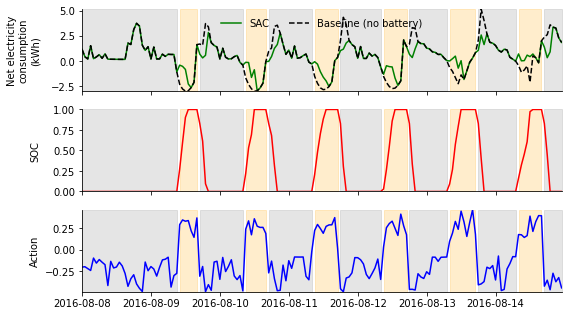

Building 12:


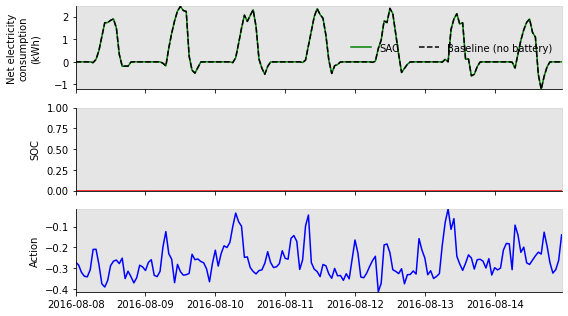

Building 15:


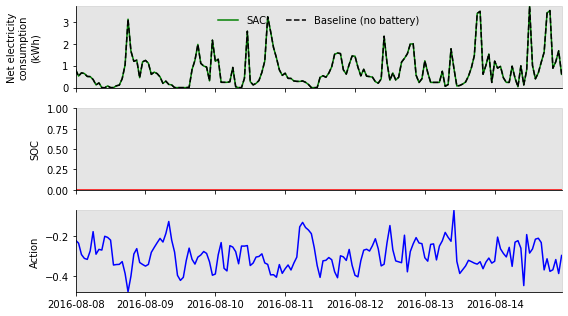

In [22]:
# for a selected week, show the baseline, RBC, SAC, battery SOC,
buildings = [2, 4, 7, 12, 15]
start_timestamp = '2016-08-08'
end_timestamp = '2016-08-15'
row_count = 3
column_count = 1

for b in buildings:
    print(f'Building {b}:')
    sac_data = DATABASE.query_table(f"""
    SELECT
        g.seed,
        d.episode,
        d.time_step,
        d.timestamp,
        CAST(LTRIM(d.building_name, 'Building_') AS INTEGER) AS building_id,
        d.net_electricity_consumption,
        d.net_electricity_consumption_without_storage,
        d.electrical_storage_soc/m.value AS electrical_storage_soc
    FROM detailed_summary d
    INNER JOIN (SELECT * FROM grid WHERE seed = (SELECT MIN(seed) FROM grid)) g ON g.simulation_id = d.simulation_id
    CROSS JOIN (SELECT MAX(electrical_storage_soc) AS value FROM detailed_summary) m
    WHERE
        CAST(LTRIM(d.building_name, 'Building_') AS INTEGER) = {b}
        AND d.episode = (SELECT MAX(episode) FROM detailed_summary)
        AND d.timestamp BETWEEN '{start_timestamp}' AND '{end_timestamp}'
    ORDER BY
        d.timestamp
    """)
    rbc_data = RBC_DATABASE.query_table(f"""
    SELECT
        d.time_step,
        d.timestamp,
        CAST(LTRIM(d.building_name, 'Building_') AS INTEGER) AS building_id,
        d.net_electricity_consumption AS rbc_net_electricity_consumption,
        d.electrical_storage_soc/m.value AS rbc_electrical_storage_soc
    FROM detailed_summary d
    CROSS JOIN (SELECT MAX(electrical_storage_soc) AS value FROM detailed_summary) m
    WHERE
        CAST(LTRIM(d.building_name, 'Building_') AS INTEGER) = {b}
        AND d.timestamp BETWEEN '{start_timestamp}' AND '{end_timestamp}'
    ORDER BY
        d.timestamp
    """)
    rbc_data = rbc_data.merge(RBC_ACTIONS, on=['time_step', 'building_id'], how='left')
    rbc_data = rbc_data.rename(columns={'action':'rbc_action'})
    rbc_data = rbc_data.drop(columns=['episode', 'seed'])
    sac_data = sac_data.merge(rbc_data, on=['timestamp', 'time_step', 'building_id'], how='left')
    sac_data = sac_data.merge(ACTIONS, on=['time_step', 'episode', 'building_id', 'seed'], how='left')
    sac_data['timestamp'] = pd.to_datetime(sac_data['timestamp'])
    sac_data['charge'] = 0
    sac_data.loc[(sac_data['action'] < 0), 'charge'] = 1
    sac_data.loc[(sac_data['action'] > 0), 'charge'] = 2
    sac_data['cumsum'] = (sac_data['charge'] != sac_data['charge'].shift()).cumsum()
    
    fig, axs = plt.subplots(row_count, column_count, figsize=(8*column_count, 1.5*row_count), sharex=True)
    x, y1, y2, y3 = sac_data['timestamp'], sac_data['net_electricity_consumption'], sac_data['rbc_net_electricity_consumption'], sac_data['net_electricity_consumption_without_storage']
    axs[0].plot(x, y1, color='green', label='SAC')
    # axs[0].plot(x, y2, color='red', linestyle=':', label='RBC')
    axs[0].plot(x, y3, color='black', linestyle='--', label='Baseline (no battery)')
    axs[0].set_ylabel('Net electricity\nconsumption\n(kWh)')
    axs[0].legend(framealpha=0, ncol=3)

    y4, y5 = sac_data['electrical_storage_soc'], sac_data['rbc_electrical_storage_soc']
    axs[1].plot(x, y4, color='red')
    # axs[1].plot(x, y5, color='red', linestyle=':')
    axs[1].set_ylim(0, 1)
    axs[1].set_ylabel('SOC')
    
    y6, y7 = sac_data['action'], sac_data['rbc_action']
    axs[2].plot(x, y6, color='blue')
    # axs[2].plot(x, y7, color='red', linestyle=':')
    # axs[2].set_ylim(-1, 1)
    axs[2].set_ylabel('Action')

    for (c, _), g_data in sac_data[sac_data['charge'] > 0].groupby(['charge', 'cumsum']):
        color = 'grey' if c == 1 else 'orange'
        for ax in fig.axes:
            y = ax.get_ylim()
            ax.fill_betweenx(y, g_data['timestamp'].min(), g_data['timestamp'].max(), color=color, alpha=0.2)

    for ax in fig.axes:
        for s in ['right','top']:
            ax.spines[s].set_visible(False)

    fig.align_ylabels()
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_1_0_building_{b}_profile_snapshot.pdf'),bbox_inches='tight',transparent=True)
    plt.show()
    # assert False


# Battery Electricity Consumption

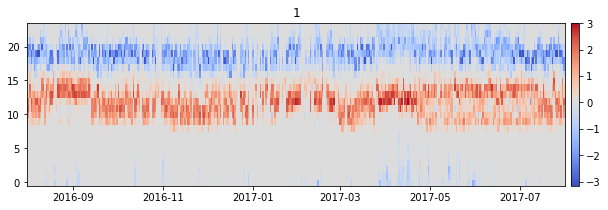

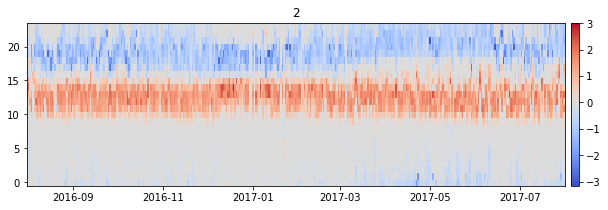

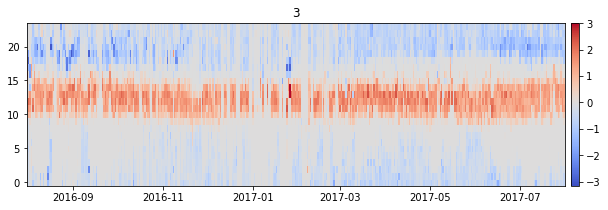

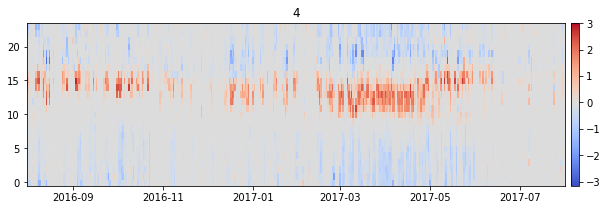

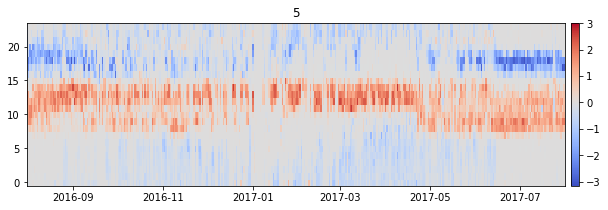

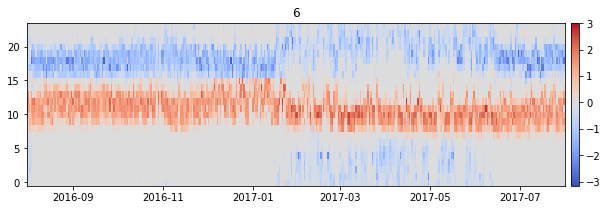

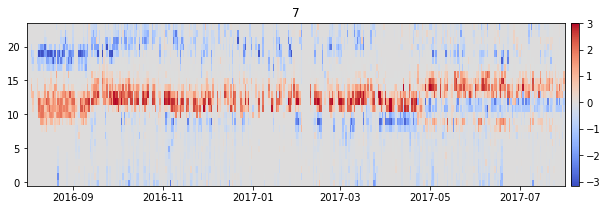

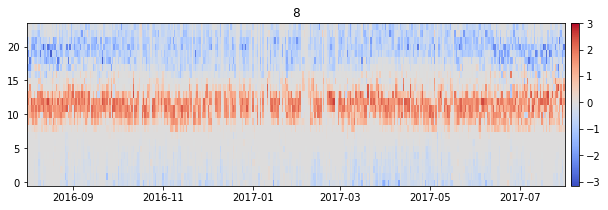

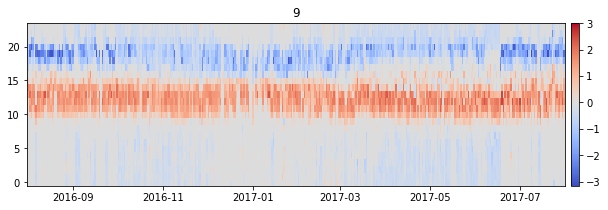

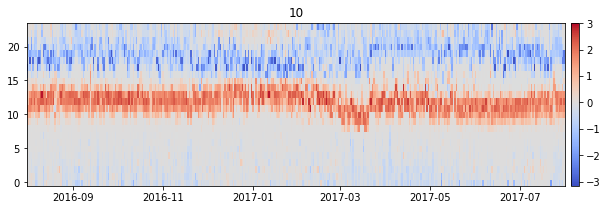

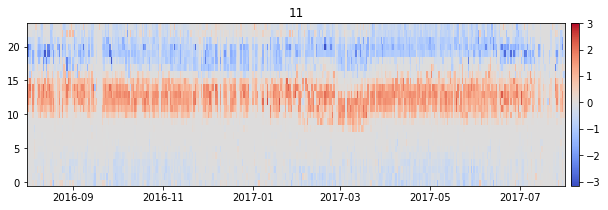

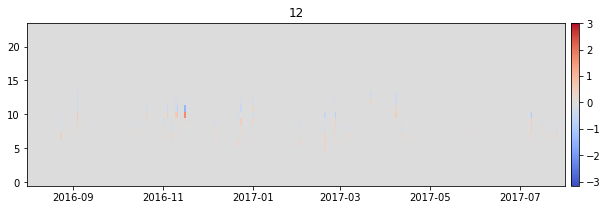

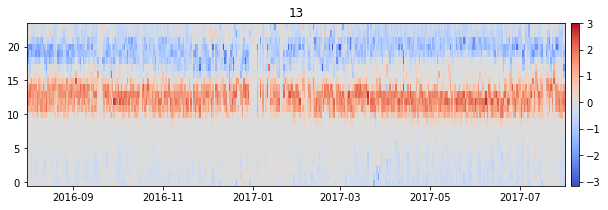

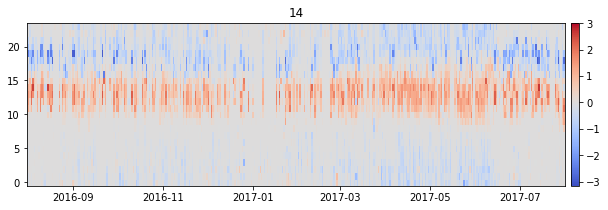

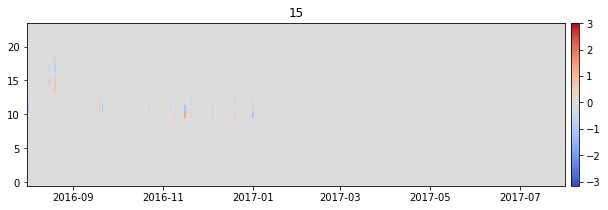

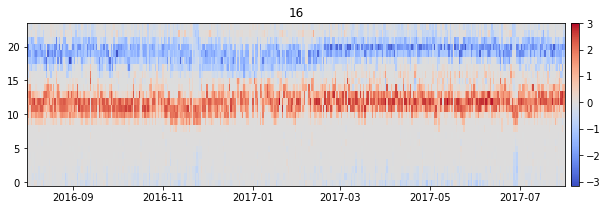

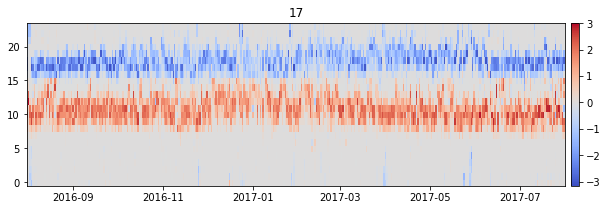

In [11]:
cmap = 'coolwarm'
vcenter = 0.0
# vmin = plot_data['value'].min()
# vmax = plot_data['value'].max()
divnorm = colors.TwoSlopeNorm(vcenter=vcenter)

for b in range(1,18):
    data = DATABASE.query_table(f"""
    SELECT
        d.timestamp,
        AVG(d.electrical_storage_electricity_consumption) AS value
    FROM detailed_summary d
    WHERE 
        CAST(LTRIM(d.building_name, 'Building_') AS INTEGER) = {b}
        AND d.episode = (SELECT MAX(episode) FROM detailed_summary)
    GROUP BY
        d.timestamp
    """)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['date'] = data['timestamp'].dt.normalize()
    data['hour'] = data['timestamp'].dt.hour
    data = data.pivot(index='hour', columns='date', values='value')
    x, y, z = data.columns, data.index, data.values
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    pcm = ax.pcolormesh(x, y, z, shading='nearest', cmap=cmap, norm=divnorm, edgecolors='black', linewidth=0.0)
    _ = fig.colorbar(pcm, ax=ax, orientation='vertical', label=None, fraction=0.025, pad=0.01)
    ax.set_title(b)
    plt.show()
    # assert False
    

- Are 12 and 15 not charging at all because they are aware of no PV? But 12 has PV so why is it not doing anything. Well from an SOC pov, 12 has nothing to discharge for. Load is 0 at night and morning; however, it is possible that the actions that lead to no change in soc are non-zero so we need to look at actions before making conclusions. only then can we say that the agnet has learned to do nothing since there is nothing to charge/discharge for.

# ZNE Analysis

In [12]:
query = """
SELECT
    d.timestamp,
    d.resolution,
    CAST(LTRIM(d.building_name, 'Building_') AS INTEGER) AS building_id,
    CASE WHEN AVG(d.net_electricity_consumption) <= 0 THEN 1 ELSE 0 END AS control_is_net_zero,
    CASE WHEN AVG(d.net_electricity_consumption_without_storage) <= 0 THEN 1 ELSE 0 END AS no_control_is_net_zero,
    AVG(d.value) AS value
FROM (
    SELECT
        d.timestamp,
        'hourly' AS resolution,
        d.building_name,
        d.net_electricity_consumption,
        d.net_electricity_consumption_without_storage,
        d.net_electricity_consumption/d.net_electricity_consumption_without_storage AS value
    FROM detailed_summary d
    WHERE d.episode = (SELECT MAX(episode) FROM detailed_summary)

    UNION ALL

    SELECT
        DATE(d.timestamp) AS timestamp,
        'daily' AS resolution,
        d.building_name,
        SUM(d.net_electricity_consumption) AS net_electricity_consumption,
        SUM(d.net_electricity_consumption_without_storage) AS net_electricity_consumption_without_storage,
        SUM(d.net_electricity_consumption)/SUM(d.net_electricity_consumption_without_storage) AS value
    FROM detailed_summary d
    WHERE d.episode = (SELECT MAX(episode) FROM detailed_summary)
    GROUP BY
        DATE(d.timestamp),
        d.building_name

    UNION ALL

    SELECT
        MAX(d.timestamp) AS timestamp,
        'annually' AS resolution,
        d.building_name,
        SUM(d.net_electricity_consumption) AS net_electricity_consumption,
        SUM(d.net_electricity_consumption_without_storage) AS net_electricity_consumption_without_storage,
        SUM(d.net_electricity_consumption)/SUM(d.net_electricity_consumption_without_storage) AS value
    FROM detailed_summary d
    WHERE d.episode = (SELECT MAX(episode) FROM detailed_summary)
    GROUP BY
        STRFTIME('%Y', d.timestamp),
        d.building_name
) d
GROUP BY
    d.timestamp,
    d.resolution,
    d.building_name
"""
data_list = []

for d, a in zip([DATABASE, RBC_DATABASE], ['SAC', 'RBC']):
    zero_net_energy_data = d.query_table(query)
    zero_net_energy_data['agent'] = a
    data_list.append(zero_net_energy_data)

zero_net_energy_data = pd.concat(data_list, ignore_index=True, sort=False)
zero_net_energy_data['timestamp'] = pd.to_datetime(zero_net_energy_data['timestamp'])
zero_net_energy_data['month'] = zero_net_energy_data['timestamp'].dt.month

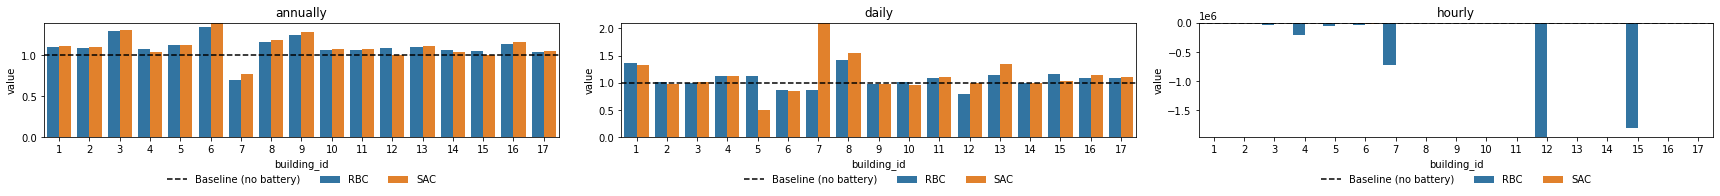

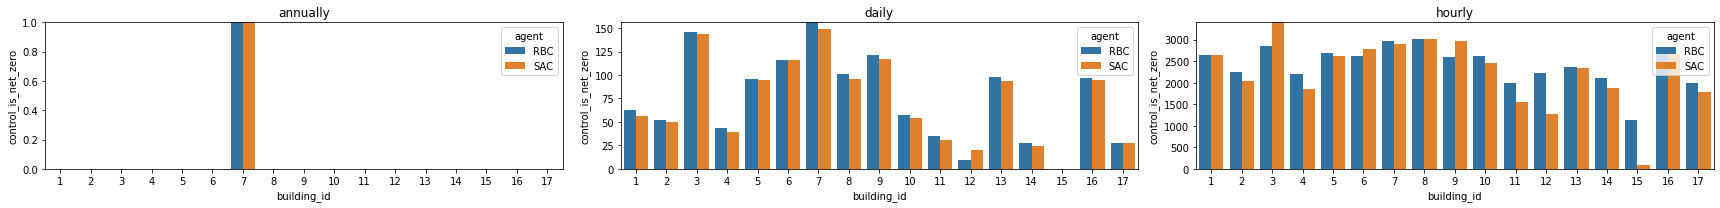

In [13]:
plot_data = zero_net_energy_data.groupby(['resolution', 'building_id', 'agent'])[['value']].mean().reset_index()
row_count = 1
column_count = len(plot_data['resolution'].unique())
fig, _ = plt.subplots(row_count, column_count, figsize=(column_count*8, row_count*3))

for i, (ax, (r, r_data)) in enumerate(zip(fig.axes, plot_data.groupby(['resolution']))):
    sns.barplot(x='building_id', y='value', data=r_data, hue='agent', ax=ax)
    ax.set_title(r)
    ax.axhline(1.0, color='black', linestyle='--', label='Baseline (no battery)')
    ax.legend(bbox_to_anchor=(0.5,-0.25),
            loc='upper center',
            framealpha=0,
            ncol=3)

plt.tight_layout()
plt.show()

plot_data = zero_net_energy_data.groupby(['resolution', 'building_id', 'agent'])[['control_is_net_zero']].sum().reset_index()
row_count = 1
column_count = len(plot_data['resolution'].unique())
fig, _ = plt.subplots(row_count, column_count, figsize=(column_count*8, row_count*3))

for i, (ax, (r, r_data)) in enumerate(zip(fig.axes, plot_data.groupby(['resolution']))):
    sns.barplot(x='building_id', y='control_is_net_zero', data=r_data, hue='agent', ax=ax)
    ax.set_title(r)

plt.tight_layout()
plt.show()

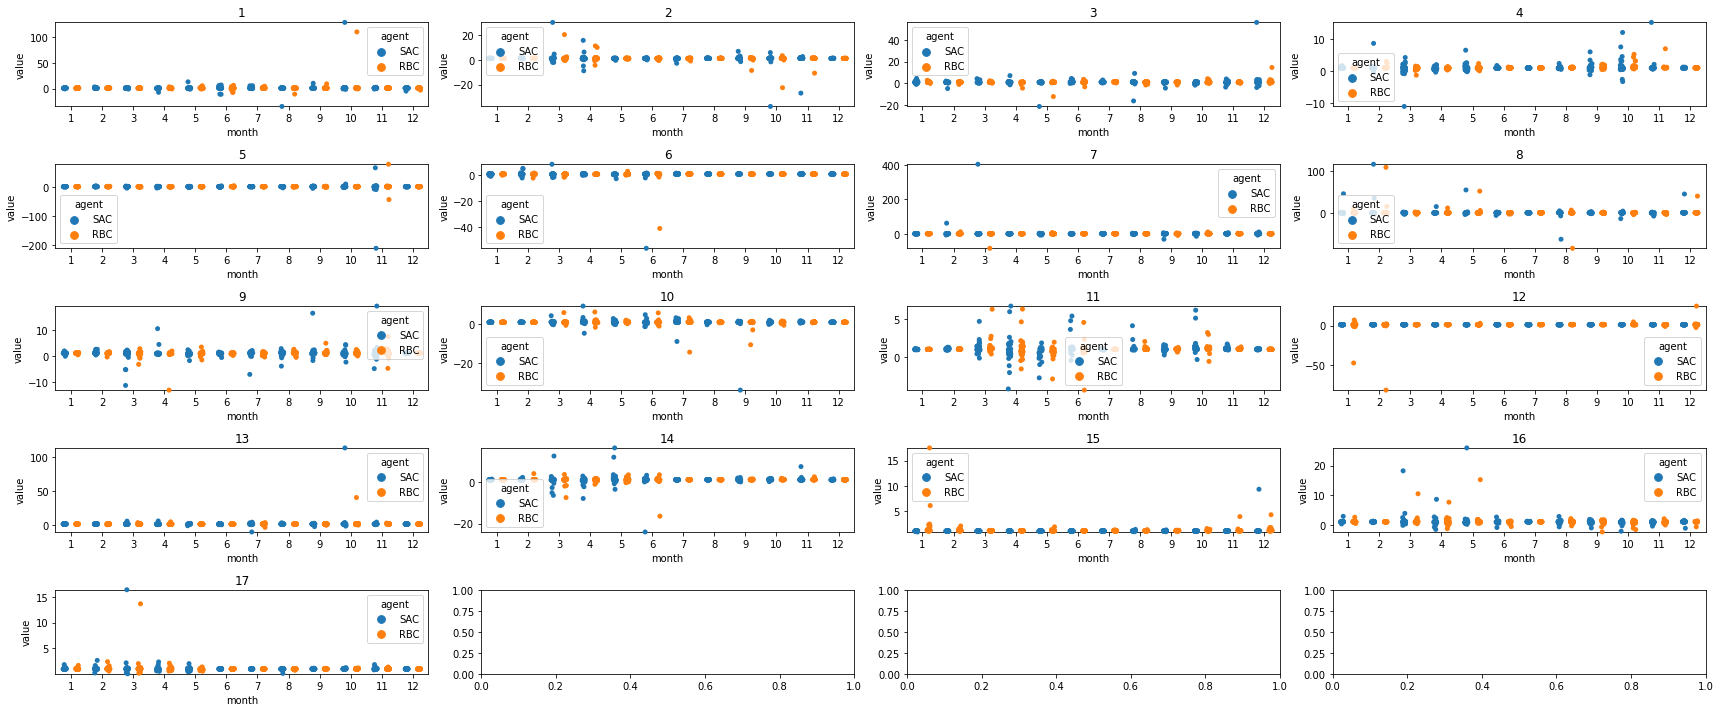

In [14]:
plot_data = zero_net_energy_data[zero_net_energy_data['resolution']=='daily'].copy()
column_count_limit = 4
building_count = zero_net_energy_data['building_id'].nunique()
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
fig, _ = plt.subplots(row_count, column_count, figsize=(column_count*6, row_count*2))

for i, (ax, (b, b_data)) in enumerate(zip(fig.axes, plot_data.groupby(['building_id']))):
    sns.stripplot(x='month', y='value', hue='agent', data=b_data, ax=ax, dodge=True, clip_on=False)
    ax.set_title(b)

plt.tight_layout()
plt.show()

# Save

In [15]:
building_cost_data['scope'] = 'building'
district_cost_data['scope']= 'district'
pd.concat([building_cost_data, district_cost_data], ignore_index=True, sort=False).to_csv(
    os.path.join(KWARGS['summary_directory'], 'deployment_strategy_1_0_cost_summary.csv'), index=False
)